# **Project Leyenda - Deliverable 2**

*Group* : 
|Author|Center|Promo|Mail| 
|---|---|---|---|
|De Jesus Correia Alexandre|Nanterre|FISE INFO A5|alexandre.dejesuscorreia@viacesi.fr|
|Charlut Steven|Nanterre|FISE INFO A5|steven.charlut@viacesi.fr|
|Debraize Killian|Nanterre|FISE INFO A5|killian.debraize@viacesi.fr|
|Raies Youssef|Nanterre|FISE INFO A5|youssef.raies@viacesi.fr|
|Kinya Mwongera Sharon|Nanterre|FISE INFO A5|sharon.kinyamwongera@viaceis.fr|

<br>
<img src ="https://i.imgflip.com/96cuk7.jpg" width="500">

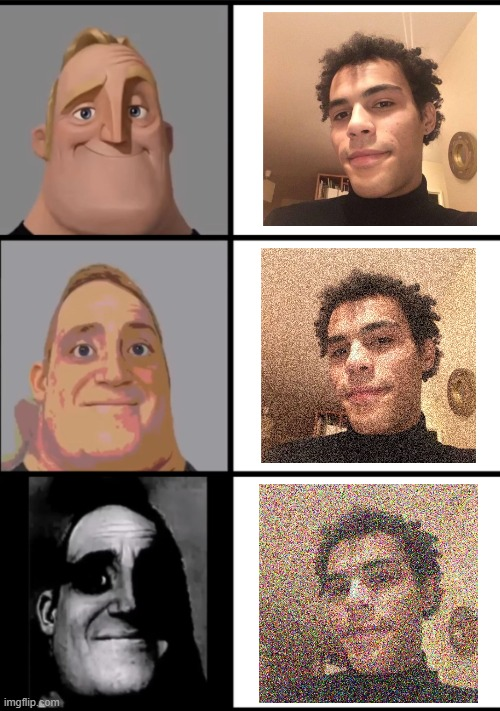


In [3]:
%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random


# Introduction Delivrable 2

debruitage importance dans le machine learning explication quand j'aurais le temps : 

bla bla bla bla bla

# 1. File Loading Section
## Load the dataset 


In [5]:
# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)  
    return images  


def check_image_resolutions(folder):
    resolutions = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            resolutions.append(img.shape[:2])  # (hauteur, largeur)
    return resolutions


In [6]:
base_dir = os.getcwd()
relative_path = r"..\..\DataSets\Dataset_delivrable_2\Dataset"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

## distribution des résolutions d'image

Nombre de résolutions uniques : 54


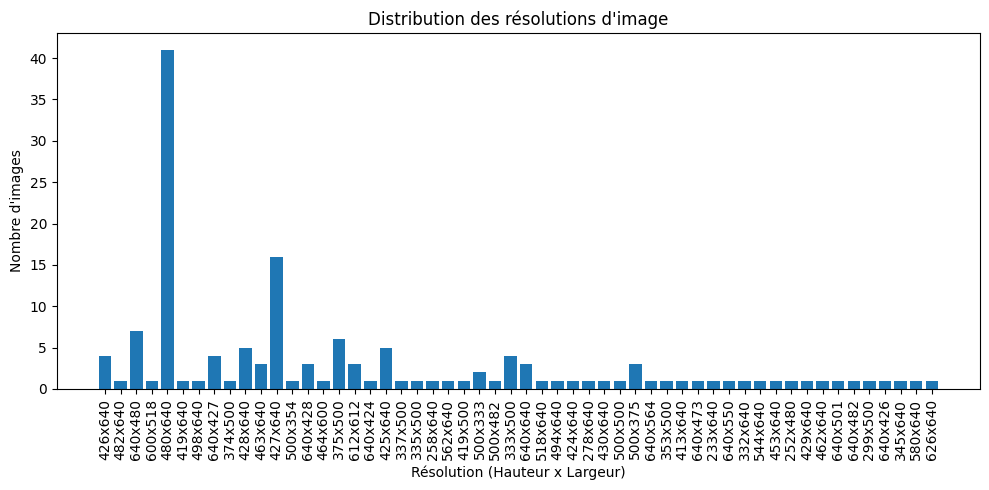

In [7]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def check_image_resolutions(dataset_dir):
    """
    Cette fonction parcourt un répertoire contenant des images et renvoie une liste des résolutions (hauteur, largeur).
    """
    from PIL import Image

    image_resolutions = []
    
    # Parcours des fichiers dans le répertoire
    for filename in os.listdir(dataset_dir):
        file_path = os.path.join(dataset_dir, filename)
        
        try:
            # Ouverture de l'image pour obtenir sa résolution
            with Image.open(file_path) as img:
                resolution = img.size  # (largeur, hauteur)
                image_resolutions.append(resolution[::-1])  # Inverser pour avoir (hauteur, largeur)
        except Exception as e:
            print(f"Erreur lors de l'ouverture du fichier {filename}: {e}")

    return image_resolutions

# Charger les résolutions d'images
image_resolutions = check_image_resolutions(dataset_dir)

# Obtenir les résolutions uniques
unique_resolutions = set(image_resolutions)
print(f"Nombre de résolutions uniques : {len(unique_resolutions)}")

# Comptage des occurrences de chaque résolution
resolution_counter = Counter([f"{res[0]}x{res[1]}" for res in image_resolutions])

# Préparer les données pour le graphique
resolutions, counts = zip(*resolution_counter.items())  # Récupère les résolutions et les fréquences

# Tracer l'histogramme
plt.figure(figsize=(10, 5))
plt.bar(resolutions, counts)  # Utilisation de bar plot pour plus de clarté
plt.xticks(rotation=90)
plt.title("Distribution des résolutions d'image")
plt.xlabel("Résolution (Hauteur x Largeur)")
plt.ylabel("Nombre d'images")
plt.tight_layout()  # Ajuste automatiquement pour éviter le chevauchement du texte
plt.show()


- Résolution dominante (640x480) :

    - La résolution 640x480 est clairement la plus courante, avec environ 40 images. Cela représente probablement une résolution standard pour une partie importante des images dans notre dataset.
    cette résolution est standard pour des images issues d'anciennes caméras, de captures d'écran ou de certains types de vidéos.

- Variété de résolutions :

    - Bien que la résolution 640x480 domine, le dataset présente une grande variété de résolutions (54 résolutions uniques),
    Certaines résolutions sont très peu représentées, avec seulement une ou deux images par résolution.

In [8]:
# Load dataset and resize images
dataset_images = load_images_from_folder(dataset_dir)
num_images = len(dataset_images)
print(f"Nombre d'images dans notre dataset : {num_images}")

Nombre d'images dans notre dataset : 148


## verification de l'état du data set

In [9]:
def load_images_with_check(folder):
    images = []
    corrupted_files = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)  
            else:
                corrupted_files.append(filename) 
        except Exception as e:
            print(f"Erreur lors du chargement de {filename}: {e}")
            corrupted_files.append(filename) 
    return images, corrupted_files
dataset_images, corrupted_files = load_images_with_check(dataset_dir)

# Afficher le nombre d'images corrompues
print(f"Nombre d'images corrompues ou manquantes : {len(corrupted_files)}")

Nombre d'images corrompues ou manquantes : 0


# data exploration 

## Visualisation du data set

nous avons ici un data set realtivement petit pour effectuer du deep learning dessus

- Conséquences d'un petit dataset
Risque de surapprentissage (overfitting) : Avec un petit dataset, il est facile pour un modèle de surapprendre les données, c'est-à-dire de mémoriser les images spécifiques au lieu d'apprendre des motifs généraux. Cela signifie que votre modèle pourrait bien fonctionner sur le jeu d'entraînement mais mal sur de nouvelles images (ou un jeu de test).

- Manque de diversité : Si les images sont trop similaires les unes aux autres, le modèle risque de ne pas apprendre à gérer des variations plus larges (comme différents types de bruit ou de variations de lumière), ce qui peut affecter sa capacité à débruiter efficacement les images nouvelles ou non vues.

- Limitation des performances : Un petit dataset limite la quantité d'informations que le modèle peut exploiter, ce qui pourrait limiter ses performances finales, surtout sur des architectures complexes comme les autoencodeurs convolutionnels, qui ont beaucoup de paramètres à entraîner.

In [10]:
def display_sample_images(images, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))): 
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)) 
        plt.axis('off')  
    plt.show()

def calculate_image_statistics(images):
   
    pixel_values = np.concatenate([img.ravel() for img in images]) 
    mean = np.mean(pixel_values)
    median = np.median(pixel_values)
    std = np.std(pixel_values)
    
    print(f"Moyenne des pixels: {mean:.4f}")
    print(f"Médiane des pixels: {median:.4f}")
    print(f"Écart-type des pixels: {std:.4f}")


def plot_color_distribution(images):
    reds = np.concatenate([img[:, :, 2].ravel() for img in images]) 
    greens = np.concatenate([img[:, :, 1].ravel() for img in images])  
    blues = np.concatenate([img[:, :, 0].ravel() for img in images])  
    
    plt.figure(figsize=(10, 5))
    plt.hist(reds, bins=50, color='red', alpha=0.6, label='Rouge')
    plt.hist(greens, bins=50, color='green', alpha=0.6, label='Vert')
    plt.hist(blues, bins=50, color='blue', alpha=0.6, label='Bleu')
    plt.title("Distribution des intensités des canaux de couleur")
    plt.xlabel("Valeur de pixel")
    plt.ylabel("Nombre de pixels")
    plt.legend()
    plt.show()

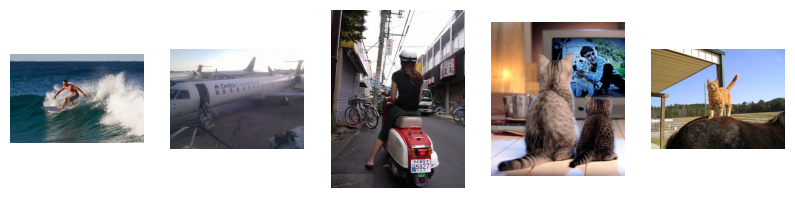

In [11]:
display_sample_images(dataset_images)

ensuite on calcule la distribution des valeurs de pixels de notre jeu de données

In [12]:
calculate_image_statistics(dataset_images)

Moyenne des pixels: 117.6791
Médiane des pixels: 115.0000
Écart-type des pixels: 71.6981


Dans notre dataset d'images, après avoir calculé la moyenne, la médiane et l'écart-type des valeurs de pixels sans redimensionner les images, nous obtenons les résultats suivants :

    Moyenne des pixels : 117.6791
    Médiane des pixels : 115.0000
    Écart-type des pixels : 71.6981

Voici ce que nous pouvons en déduire :

1. Moyenne des pixels :

    La moyenne des pixels est de 117.6791 sur une échelle de [0, 255], ce qui représente des valeurs de pixels proches du milieu de cette plage. Cela signifie que, dans l'ensemble, nos images ont une luminosité moyenne à légèrement plus sombre que le milieu (qui serait 127.5).
    Une moyenne autour de 117 indique que nos images contiennent une combinaison équilibrée de zones sombres et claires, mais avec une légère prédominance des teintes plus sombres.

2. Médiane des pixels :

    La médiane des pixels est de 115.0000, très proche de la moyenne. Cela suggère que la distribution des valeurs de pixels est relativement symétrique. En d'autres termes, la plupart des pixels dans nos images sont répartis autour de cette valeur médiane, avec peu de biais vers des valeurs extrêmement sombres ou extrêmement claires.
    La proximité entre la moyenne et la médiane indique qu'il n'y a pas de valeurs extrêmes ou de déséquilibre important dans la répartition des intensités de pixels.

3. Écart-type des pixels :
    L'écart-type de 71.6981 montre qu'il y a une variabilité significative dans les valeurs de pixels dans notre dataset. Un écart-type élevé indique que les valeurs des pixels sont largement dispersées autour de la moyenne, ce qui signifie que nos images contiennent à la fois des zones très sombres et très claires, avec un bon contraste.
    Cela peut être intéressant pour les algorithmes de traitement d'images, car un tel contraste pourrait améliorer la capacité de notre modèle à distinguer les détails dans les images.

Conclusion générale :

Les statistiques des pixels montrent que nos images ont une luminosité moyenne légèrement inférieure à la moyenne de l'échelle [0, 255], avec une bonne distribution symétrique des valeurs de pixels et un fort contraste. Cela est idéal pour une phase de débruitage ou d'amélioration des images, car nos images contiennent une variété d'intensités et un contraste important, ce qui peut aider le modèle à mieux capter les détails et les zones de transition dans les images.

Ces observations nous donnent un bon aperçu de la distribution des pixels dans notre dataset, et confirment que nos images présentent une diversité de zones lumineuses et sombres, ce qui pourrait être bénéfique pour des algorithmes de traitement d'images comme un autoencodeur convolutionnel (CAE).

## Répartition des intensités des pixels

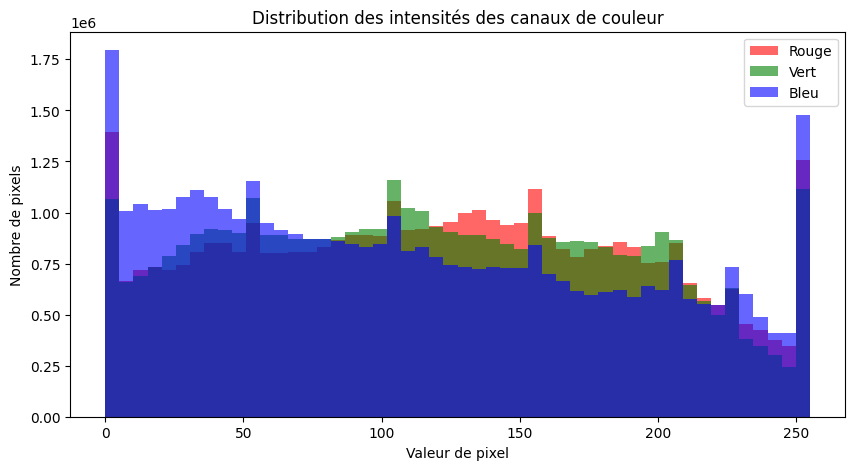

In [13]:
plot_color_distribution(dataset_images)

- Contraste dans les images :

     - Les pics aux extrêmes 0 et 1 indiquent un contraste élevé dans les images, ce qui est une caractéristique à prendre en compte pour le débruitage. Le débruitage pourrait devoir préserver ces zones de fort contraste pour maintenir la netteté des bords et des zones de transition rapide dans les images.

- Variabilité des couleurs :

    - Les différentes distributions entre les canaux montrent que nos images contiennent une bonne diversité de couleurs, bien qu'il y ait une légère prédominance de teintes bleutées. Cela peut affecter la façon dont l'autoencodeur doit traiter chaque canal pour améliorer la qualité globale des images tout en respectant la variation des couleurs.

- Ajout de bruit et débruitage :

    - Lorsque nous ajouterons du bruit à ces images pour entraîner notre autoencodeur, il est essentiel de voir comment le bruit affecte ces pics aux valeurs extrêmes (0 et 1) et les zones intermédiaires. Lors du débruitage, l'autoencodeur devra être capable de reconstruire ces zones de fort contraste et les couleurs dominantes correctement.

## Redimensionnement du dataset

Le fait que nos images aient différentes résolutions pose plusieurs défis pour les étapes ultérieures, notamment pour l'entraînement d'un modèle de machine learning. Les modèles de deep learning, en particulier les réseaux de neurones convolutionnels (CNN), nécessitent que toutes les images d'entrée aient les mêmes dimensions. Cela permet d'uniformiser la structure des données, facilitant ainsi l'apprentissage et l'application des filtres de convolution.

Voici les raisons pour lesquelles un redimensionnement est important et bénéfique pour notre dataset :

- Uniformisation des données :

    - Nos images ont des résolutions variées, ce qui peut entraîner des incohérences dans les résultats des opérations d'apprentissage automatique. En redimensionnant toutes les images à une taille commune (par exemple, 128x128 ou 256x256), nous garantissons que toutes les images ont le même nombre de pixels, ce qui est essentiel pour une entrée cohérente dans un modèle de machine learning.
    
    - Optimisation des performances :
    Les résolutions très élevées nécessitent davantage de mémoire et de puissance de calcul, ce qui peut ralentir considérablement le processus d'entraînement. Le redimensionnement permet de réduire la complexité computationnelle, tout en conservant les informations visuelles importantes.

En redimensionnant les images à une taille raisonnable (par exemple, 128x128 ou 256x256), nous obtenons un bon compromis entre la conservation des détails visuels et les exigences en matière de ressources matérielles.

- Réduction des biais liés à la taille :

Si nous avons des images de résolutions très différentes (grandes et petites), les plus grandes images pourraient avoir plus d'importance dans l'apprentissage du modèle, car elles contiennent plus de pixels. Le redimensionnement permet de traiter chaque image de manière équitable.

- Simplification des étapes de prétraitement :
    De nombreuses techniques de prétraitement (ajout de bruit, débruitage, etc.) nécessitent également que les images aient des tailles uniformes. En appliquant un redimensionnement global, nous simplifions ces étapes et préparons les images pour un traitement optimal.
    Choix de la taille de redimensionnement
    Pour choisir la taille de redimensionnement, il est important de trouver un compromis entre la conservation des détails visuels et l'efficacité de l'entraînement du modèle. 


    - 128x128 : Cette taille est souvent utilisée dans les projets de débruitage ou de reconnaissance d'images, car elle permet de capturer suffisamment de détails tout en maintenant une faible complexité computationnelle.

    - 256x256 : Si nos images contiennent beaucoup de détails fins, un redimensionnement en 256x256 pourrait être une meilleure option. Cela conservera plus de détails visuels, mais nécessitera plus de mémoire et de temps de calcul.

In [14]:
# Fonction pour redimensionner toutes les images du dataset à une taille donnée
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_img = resized_img.astype('float16') / 255.0  
        resized_images.append(resized_img)
    return np.array(resized_images, dtype=np.float16)  # Convertir en float16


# augmentation du data set 

nous allons réutiliser les photos du livrable 1 pour crée un data set plus grand nous allons en crée 3 data set suplémantaire de plusieurs taille pour répartir nos essaie :
- taille originale (148 images)
- Taille petite (1000 images)
- Taille intermédiaire ( 5000 images) 
- Taille large ( 10 000 images)


In [15]:
def create_augmented_dataset(original_images, additional_images, target_size):
    num_images_to_add = target_size - len(original_images)
    additional_images_sample = random.sample(additional_images, num_images_to_add)
    augmented_dataset = original_images + additional_images_sample

    return augmented_dataset


In [16]:
base_dir = os.getcwd()
relative_path = r"..\..\DataSets\data_set_livrable_1\Photo"
additional_dataset_dir =  os.path.normpath(os.path.join(base_dir, relative_path))

additional_images, corrupted_files = load_images_with_check(additional_dataset_dir)
print("nombre de photo dans le data set suplémentaire :",len(additional_images))
print("nombre de photo corrompu dans ce même data set :",len(corrupted_files))


nombre de photo dans le data set suplémentaire : 9997
nombre de photo corrompu dans ce même data set : 0


In [17]:
augmented_dataset_1000 = create_augmented_dataset(dataset_images, additional_images, 1000)
augmented_dataset_5000 = create_augmented_dataset(dataset_images, additional_images, 5000)
augmented_dataset_10000 = create_augmented_dataset(dataset_images, additional_images, 10000)


In [18]:
print(len(augmented_dataset_1000))
print(len(augmented_dataset_5000))
print(len(augmented_dataset_10000))

1000
5000
10000


In [19]:
dataset_images128 = resize_images(dataset_images, (128, 128))
dataset_images256 = resize_images(dataset_images, (256, 256))

augmented_dataset_1000_resized128 = resize_images(augmented_dataset_1000, (128, 128))
augmented_dataset_1000_resized256 = resize_images(augmented_dataset_1000, (256, 256))

augmented_dataset_5000_resized128 = resize_images(augmented_dataset_5000, (128, 128))
augmented_dataset_5000_resized256 = resize_images(augmented_dataset_5000, (256, 256))

augmented_dataset_10000_resized128 = resize_images(augmented_dataset_10000, (128, 128))
augmented_dataset_10000_resized256 = resize_images(augmented_dataset_10000, (256, 256))

In [20]:
print(augmented_dataset_1000_resized128.shape)
print(augmented_dataset_5000_resized256.shape)

(1000, 128, 128, 3)
(5000, 256, 256, 3)


In [22]:
print(dataset_images128[0][0:5, 0:5, :])

[[[0.7256 0.6904 0.639 ]
  [0.7256 0.6904 0.643 ]
  [0.7256 0.6904 0.6353]
  [0.7334 0.686  0.639 ]
  [0.7373 0.6904 0.643 ]]

 [[0.7334 0.686  0.639 ]
  [0.7295 0.682  0.6353]
  [0.7295 0.686  0.6313]
  [0.7295 0.682  0.6353]
  [0.7334 0.686  0.639 ]]

 [[0.7295 0.682  0.6353]
  [0.7295 0.682  0.6353]
  [0.7295 0.686  0.6313]
  [0.7295 0.682  0.6353]
  [0.7295 0.682  0.6353]]

 [[0.7295 0.682  0.6353]
  [0.7295 0.682  0.6353]
  [0.7256 0.682  0.6274]
  [0.7295 0.686  0.6313]
  [0.7256 0.678  0.6313]]

 [[0.7295 0.682  0.6353]
  [0.7295 0.682  0.6353]
  [0.7295 0.686  0.6313]
  [0.7334 0.6904 0.6353]
  [0.7295 0.686  0.6313]]]


# train/test split

In [23]:
# ************************************************* Orginal data set L148 **************************************************#
# Split the original dataset resized (128x128)
train_images_orginal_R128 = dataset_images128[:int(len(dataset_images128) * 0.8)]
test_images_orginal_R128 = dataset_images128[int(len(dataset_images128) * 0.8):]
# Split the original dataset resized (256x256)
train_images_orginal_R256 = dataset_images256[:int(len(dataset_images256) * 0.8)]
test_images_orginal_R256 = dataset_images256[int(len(dataset_images256) * 0.8):]

# ************************************************* augmented data set L1000 ***********************************************#
# Split the augmented dataset 1000 resized (128x128)
train_images_augmented_L1000_R128 = augmented_dataset_1000_resized128[:int(len(augmented_dataset_1000_resized128) * 0.8)]
test_images_augmented_L1000_R128  = augmented_dataset_1000_resized128[int(len(augmented_dataset_1000_resized128) * 0.8):]

# Split the augmented dataset 1000 resized (256x256)
train_images_augmented_L1000_R256 = augmented_dataset_1000_resized256[:int(len(augmented_dataset_1000_resized256) * 0.8)]
test_images_augmented_L1000_R256  = augmented_dataset_1000_resized256[int(len(augmented_dataset_1000_resized256) * 0.8):]

# ************************************************* augmented data set L5000 ***********************************************#

# Split the augmented dataset 5000 resized (128x128)
train_images_augmented_L5000_R128 = augmented_dataset_5000_resized128[:int(len(augmented_dataset_5000_resized128) * 0.8)]
test_images_augmented_L5000_R128  = augmented_dataset_5000_resized128[int(len(augmented_dataset_5000_resized128) * 0.8):]
# Split the augmented dataset 5000 resized (256x256)
train_images_augmented_L5000_R256 = augmented_dataset_5000_resized256[:int(len(augmented_dataset_5000_resized256) * 0.8)]
test_images_augmented_L5000_R256  = augmented_dataset_5000_resized256[int(len(augmented_dataset_5000_resized256) * 0.8):]

# ************************************************* augmented data set L10 000 ***********************************************#
# Split the augmented dataset 10000 resized (128x128)
train_images_augmented_L10000_R128 = augmented_dataset_10000_resized128[:int(len(augmented_dataset_10000_resized128) * 0.8)]
test_images_augmented_L10000_R128  = augmented_dataset_10000_resized128[int(len(augmented_dataset_10000_resized128) * 0.8):]

# Split the augmented dataset 10000 resized (256x256)
train_images_augmented_L10000_R256 = augmented_dataset_10000_resized256[:int(len(augmented_dataset_10000_resized256) * 0.8)]
test_images_augmented_L10000_R256  = augmented_dataset_10000_resized256[int(len(augmented_dataset_10000_resized256) * 0.8):]


In [24]:
# Add noise to the images
def create_data_set_noise_batch(noise_factor, train_images, test_images, batch_size=500):
    train_noisy = []
    test_noisy = []
    
    for i in range(0, len(train_images), batch_size):
        batch_train = train_images[i:i+batch_size]
        noise_train = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=batch_train.shape).astype('float32')
        noisy_batch_train = np.clip(batch_train + noise_train, 0., 1.)
        train_noisy.append(noisy_batch_train)
    
    for i in range(0, len(test_images), batch_size):
        batch_test = test_images[i:i+batch_size]
        noise_test = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=batch_test.shape).astype('float32')
        noisy_batch_test = np.clip(batch_test + noise_test, 0., 1.)
        test_noisy.append(noisy_batch_test)
    
    return np.vstack(train_noisy), np.vstack(test_noisy)


In [25]:
# ************************************************* Orginal data set L148 ***********************************************#
#Add noise to the original dataset resized (128x128)
train_noisy_orginal_R128, test_noisy_orginal_R128 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_orginal_R128,test_images = test_images_orginal_R128)
#Add noise to the original dataset resized (256x256)
train_noisy_orginal_R256, test_noisy_orginal_R256 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_orginal_R256,test_images = test_images_orginal_R256)

In [26]:
# ************************************************* augmented data set L1000 ***********************************************#

#Add noise to the augmented dataset 1000 resized (128x128)
train_noisy_augmented_L1000_R128, test_noisy_augmented_L1000_R128 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_augmented_L1000_R128 ,test_images = test_images_augmented_L1000_R128,batch_size=500)
#Add noise to the augmented dataset 1000 resized (256x256)
train_noisy_augmented_L1000_R256, test_noisy_augmented_L1000_R256 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_augmented_L1000_R256,test_images = test_images_augmented_L1000_R256,batch_size=500)

In [25]:
# ************************************************* augmented data set L5000 ***********************************************#
#Add noise to the augmented dataset 5000 resized (128x128)
train_noisy_augmented_L5000_R128, test_noisy_augmented_L5000_R128 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_augmented_L5000_R128 ,test_images = test_images_augmented_L5000_R128,batch_size=250)
#Add noise to the augmented dataset 1000 resized (256x256)
train_noisy_augmented_L5000_R256, test_noisy_augmented_L5000_R256 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_augmented_L5000_R256,test_images = test_images_augmented_L5000_R256,batch_size=250)

In [25]:
# ************************************************* augmented data set L10000 ***********************************************#
#Add noise to the augmented dataset 5000 resized (128x128)
train_noisy_augmented_L10000_R128, test_noisy_augmented_L10000_R128 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_augmented_L10000_R128 ,test_images = test_images_augmented_L10000_R128,batch_size=250)
#Add noise to the augmented dataset 1000 resized (256x256)
train_noisy_augmented_L10000_R256, test_noisy_augmented_L10000_R256 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_augmented_L10000_R256,test_images = test_images_augmented_L10000_R256,batch_size=250)

In [27]:
train_noisy_orginal_R128.shape

(118, 128, 128, 3)

# autoencodeur convolutionnel (CAE)


#### Autoencodeur convolutionnel (CAE) redimen resized (128x128) 

In [29]:
# Configuration des dimensions des images
IMG_SIZE = 128                        # Taille des images (128x128)
IMG_CHANNELS = 3                      # Canaux des images (RVB)
NB_EPOCHS_DENOISE = 100               # nombre epoch alogithme debruiter
BATCH_SIZE        = 64          # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage
latent_dim = 256                  #latent space dimension
# Configuration de l'encodeur (input = image de 128x128 avec 3 canaux)
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
input_shape = (128, 128, 3)

## Grid Search

In [86]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

IMG_SIZE = 128
IMG_CHANNELS = 3
# Fonction de perte personnalisée RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
def build_autoencoder_model(hp):
    latent_dim = hp.Int('latent_dim', min_value=8, max_value=128, step=8)  # Recherche du latent space
    
    # Optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    
    # Fonction de perte
    loss = hp.Choice('loss', ['mae', 'mse', 'rmse'])
    
    if loss == 'rmse':
        loss = rmse  # Utilisation de la fonction rmse personnalisée

    # Encoder
    input_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS))

    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 128x128 -> 64x64

    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 64x64 -> 32x32

    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16

    # Latent space
    x = Flatten()(encoded)
    latent = Dense(latent_dim, activation='relu')(x)
    latent = Dropout(0.4)(latent)

    # Decoder
    x = Dense(16 * 16 * 128, activation='relu')(latent)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 16x16 -> 32x32

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 32x32 -> 64x64

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 64x64 -> 128x128

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Reconstruction finale

    # Construire le modèle
    autoencoder = Model(input_img, decoded)

    # Compiler le modèle avec les hyperparamètres
    autoencoder.compile(optimizer=optimizer, loss=loss)
    
    return autoencoder



In [88]:
from keras_tuner import RandomSearch

# Instanciation du tuner avec Random Search
tuner = RandomSearch(
    build_autoencoder_model,
    objective='val_loss',  # Critère à optimiser
    max_trials=10,  # Nombre d'essais
    executions_per_trial=1,  # Nombre d'entraînements par combinaison
    directory='autoencoder_tuning',
    project_name='denoising_autoencoder'
)

Reloading Tuner from autoencoder_tuning\denoising_autoencoder\tuner0.json


In [89]:
# Recherche des hyperparamètres
tuner.search(train_noisy_augmented_L1000_R128, train_images_augmented_L1000_R128, 
             epochs=10,  # Ajustez le nombre d'epochs
             validation_data=(test_noisy_augmented_L1000_R128, test_images_augmented_L1000_R128))

# Récupérer les meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Meilleure dimension du latent space : {best_hps.get('latent_dim')}")
print(f"Meilleur optimiseur : {best_hps.get('optimizer')}")
print(f"Meilleure fonction de perte : {best_hps.get('loss')}")


Trial 10 Complete [00h 00m 48s]
val_loss: 0.33018866181373596

Best val_loss So Far: 0.1252375692129135
Total elapsed time: 00h 10m 38s
Meilleure dimension du latent space : 112
Meilleur optimiseur : rmsprop
Meilleure fonction de perte : mse


In [33]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, BatchNormalization
# Encoder
input_img = tf.keras.Input(shape=input_shape)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)  # Réduction 128x128 -> 64x64
x = MaxPooling2D((2, 2), padding='same')(x)  

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu')(x)  # Réduction 64x64 -> 32x32
x = MaxPooling2D((2, 2), padding='same')(x)  

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu')(x)  # Réduction 32x32 -> 16x16
x = MaxPooling2D((2, 2), padding='same')(x)  # 128x128 -> 64x64

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
encoded = Conv2D(512, (3, 3), activation='relu')(x)  # Réduction 16x16 -> 8x8
encoded = MaxPooling2D((2, 2), padding='same')(x)  

# Modèle de l'encodeur
encoder_model_R128 = Model(inputs=input_img, outputs=encoded)

# Afficher le résumé de l'encodeur
encoder_model_R128.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 63, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 63, 63, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,329,408 (8.89 MB)

 Trainable params: 2,327,488 (8.88 MB)

 Non-trainable params: 1,920 (7.50 KB)

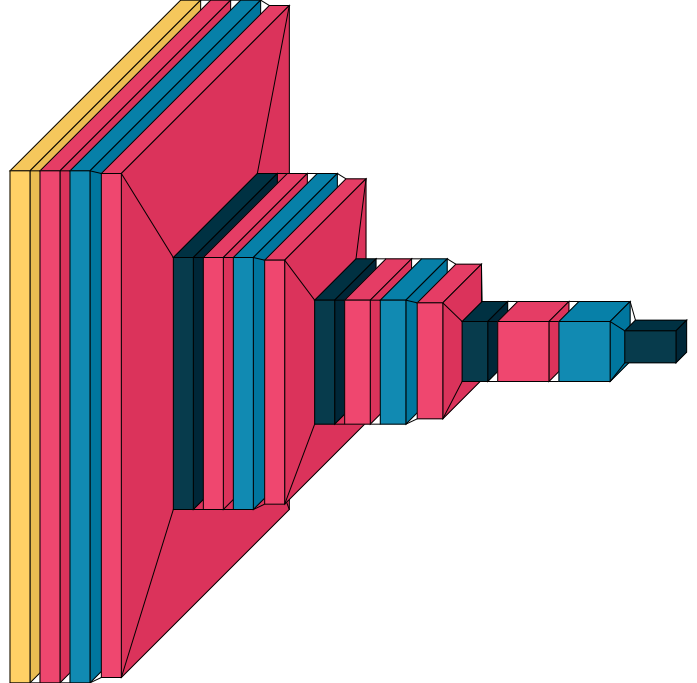

In [177]:
import visualkeras
visualkeras.layered_view(encoder_model_R128).show() # display using your system viewer
visualkeras.layered_view(encoder_model_R128)

### Projection dans l'espace latent

La projection dans l'espace latent se fait par une couche **Dense** qui prend le vecteur aplati \( h_{\text{flat}} \) et le projette dans un espace de dimension réduite \( \text{latent\_dim} \).

#### Formule :

$$
z = f\left( W_{\text{latent}} \cdot h_{\text{flat}} + b_{\text{latent}} \right)
$$

#### Où :

- \(h_{\text{flat}} \) est le vecteur aplati de la sortie de la dernière couche convolutive, de taille \( n \) (par exemple, \( n = 8 \times 8 \times 512 = 32{,}768 \)).
- \( W_{\text{latent}} \) est la matrice de poids, de taille \( (n \times \text{latent\_dim}) \), qui permet de transformer le vecteur aplati en un vecteur latent de plus petite dimension.
- \( b_{\text{latent}} \) est le biais associé à cette transformation.
- \( z \) est le vecteur de l'espace latent, de taille \( \text{latent\_dim} \).
- \( f \) est la fonction d'activation, souvent une fonction non linéaire comme ReLU.


In [34]:
x = Flatten()(encoded)
latent = Dense(latent_dim, activation='relu')(x)
latent = Dropout(0.4)(latent)

In [36]:
from tensorflow.keras.optimizers import Adam, RMSprop
# Optimiseur RMSprop 
optimizer = RMSprop()

# Fonction de perte MSE 
loss = 'mse'

# Decoder
x = Dense(8 * 8 * 512, activation='relu')(latent)
x = Reshape((8, 8, 512))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 8x8 -> 16x16

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 16x16 -> 32x32

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 32x32 -> 64x64

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 64x64 -> 128x128

# Reconstruction finale
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Reconstruction finale

# Modèle du décodeur
decoder_model_R128 = Model(inputs=latent, outputs=decoded)

# Afficher le résumé du décodeur
decoder_model_R128.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_39CLONE            │ (None, 256)            │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32768)          │     8,421,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,335,491 (47.06 MB)

 Trainable params: 12,333,571 (47.05 MB)

 Non-trainable params: 1,920 (7.50 KB)

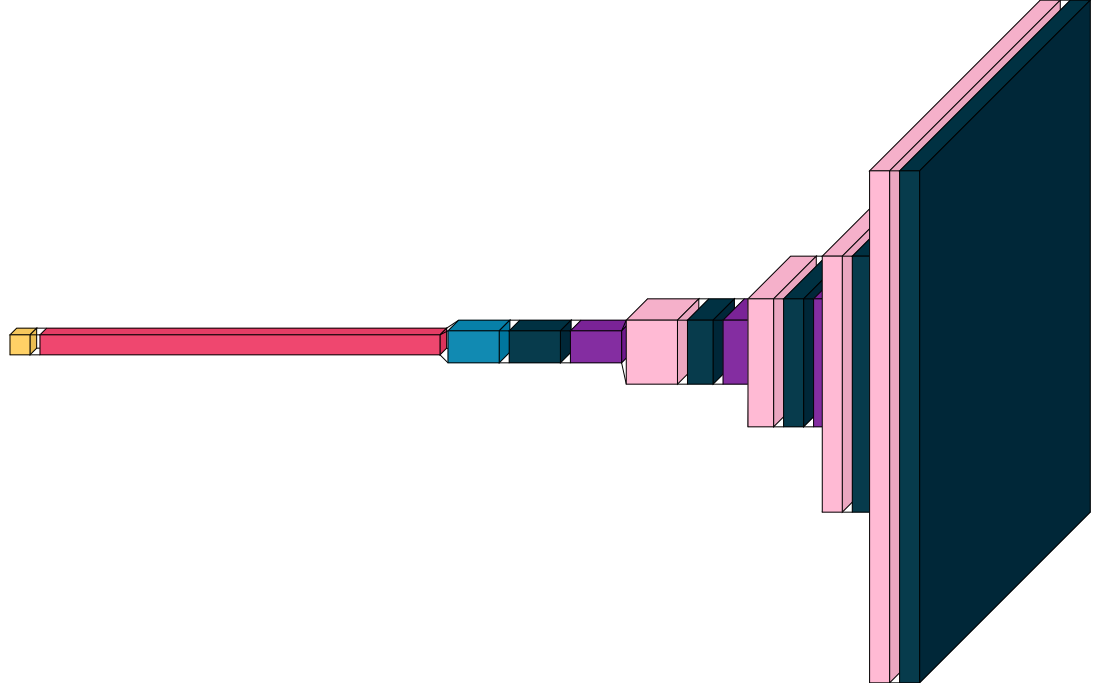

In [127]:
import visualkeras
visualkeras.layered_view(decoder_model_R128).show() # display using your system viewer
visualkeras.layered_view(decoder_model_R128)

In [37]:
# Construire le modèle
autoencoder = Model(input_img, decoded)

# Compiler le modèle avec les meilleurs hyperparamètres
autoencoder.compile(optimizer=optimizer, loss=loss)

# Affichage du résumé du modèle
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 63, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 63, 63, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32768)          │     8,421,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 512)      │         2,04

 Total params: 23,053,763 (87.94 MB)

 Trainable params: 23,049,923 (87.93 MB)

 Non-trainable params: 3,840 (15.00 KB)

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


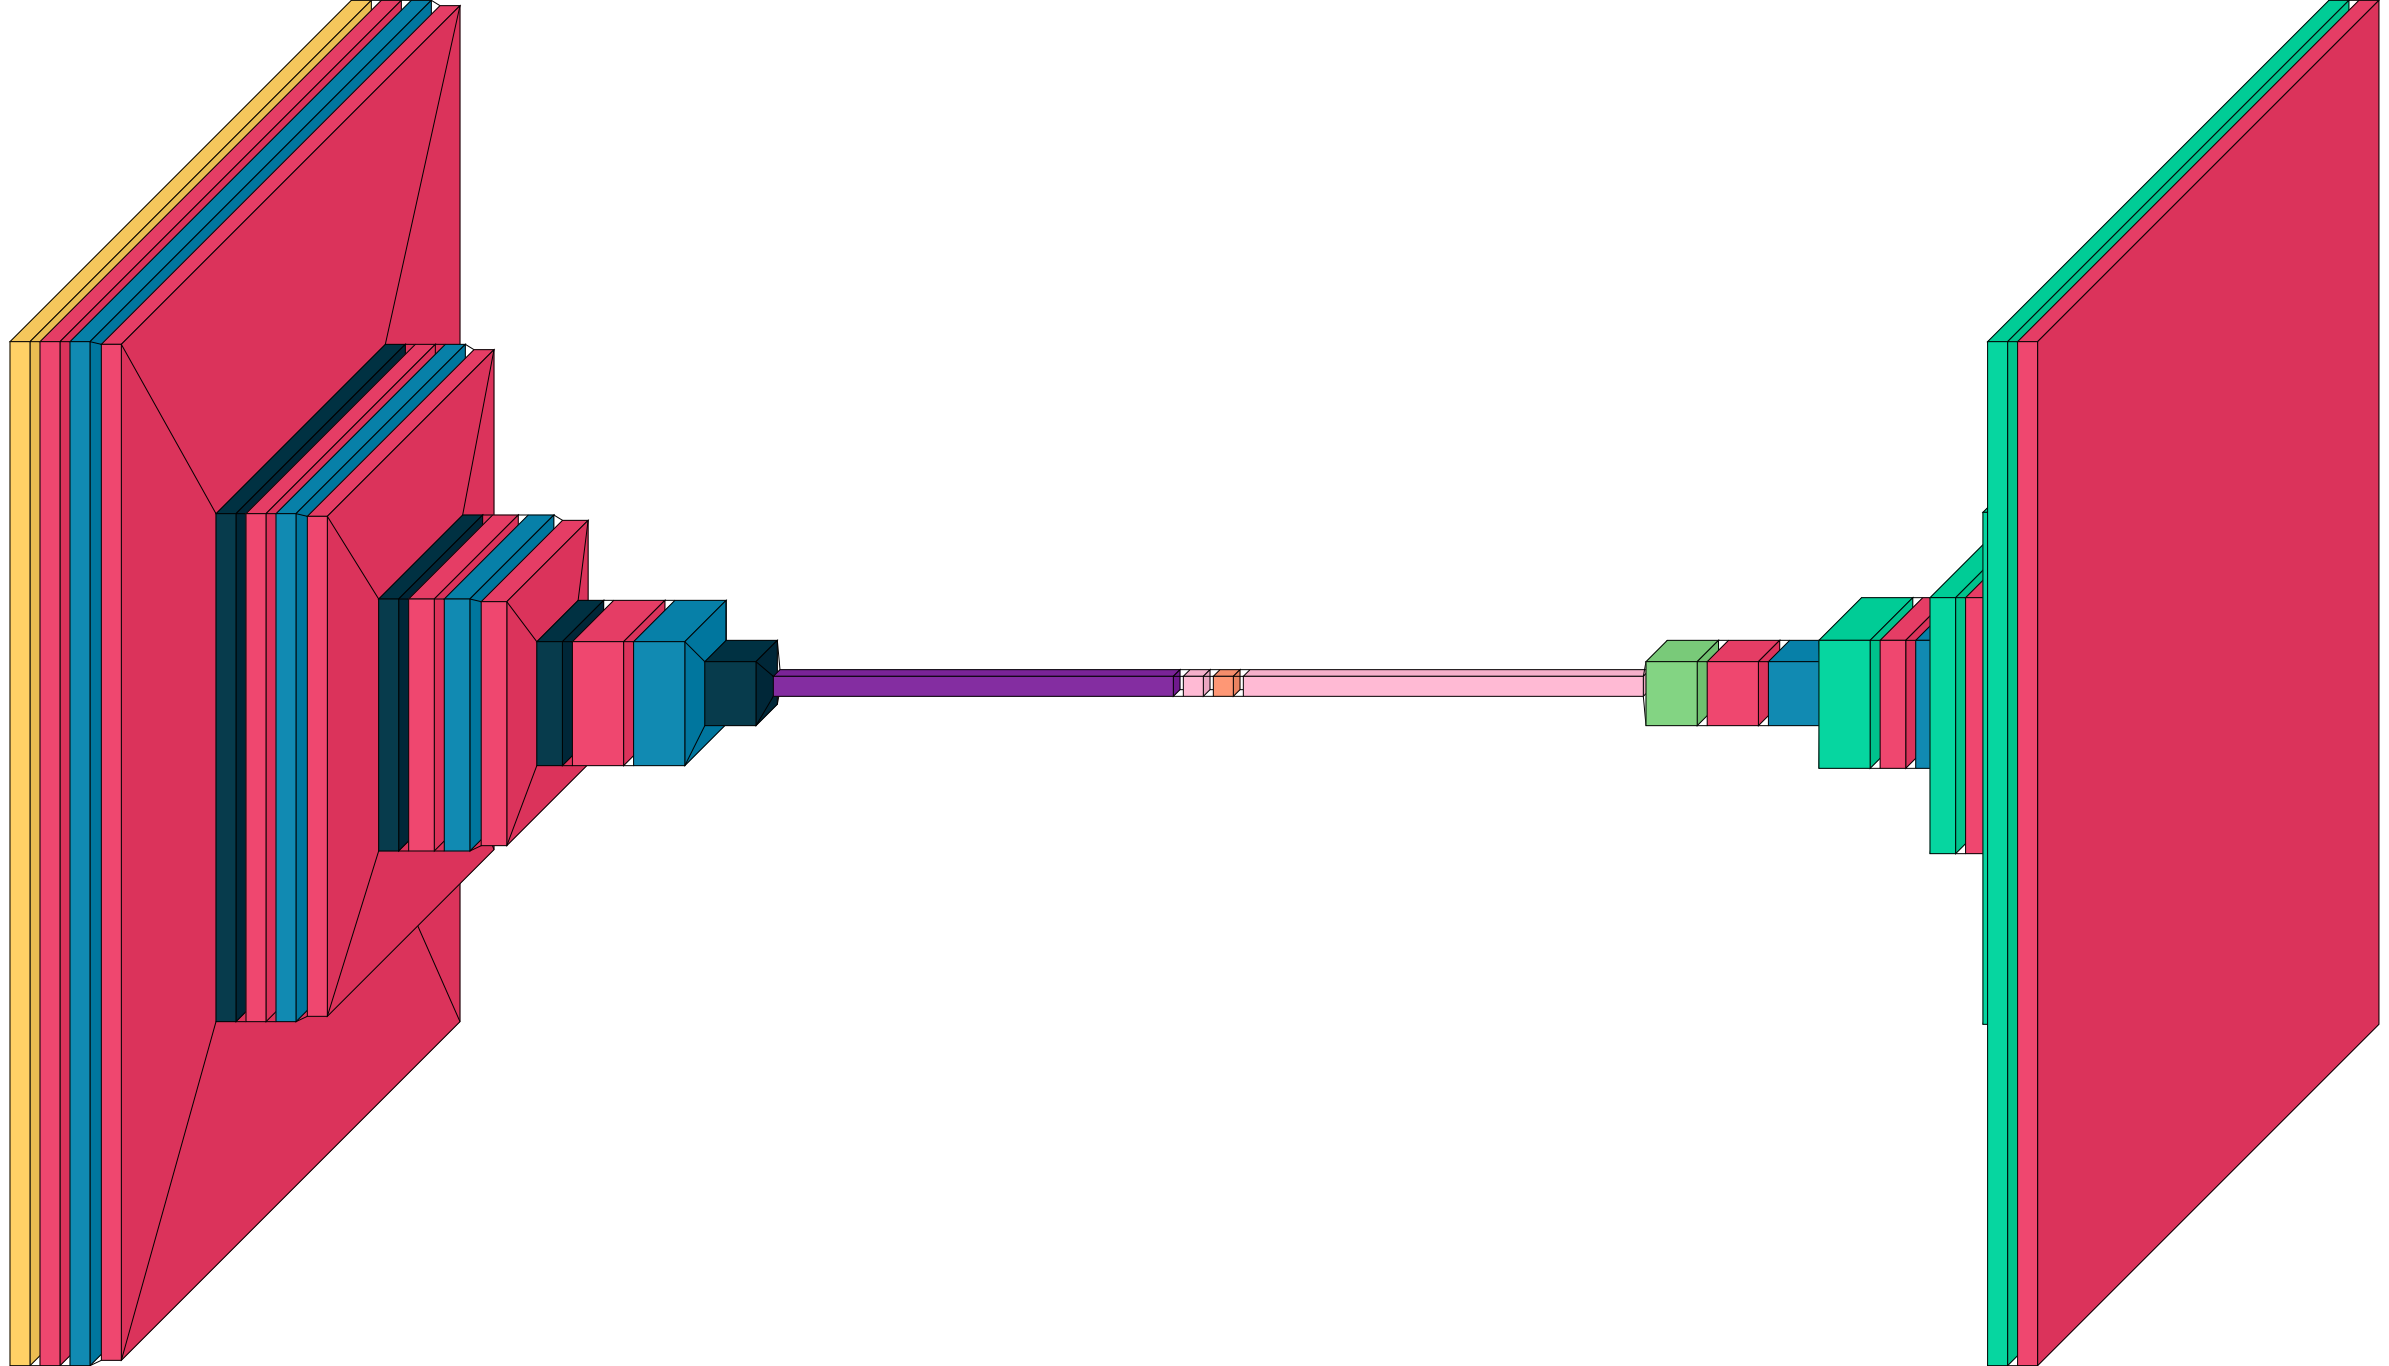

In [173]:
import visualkeras
visualkeras.layered_view(autoencoder).show() # display using your system viewer
visualkeras.layered_view(autoencoder)

In [38]:
%load_ext tensorboard

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history_R128 = autoencoder.fit(
    train_noisy_augmented_L1000_R128, train_images_augmented_L1000_R128,     # Données d'entrée bruitées et images originales correspondantes
    epochs=NB_EPOCHS_DENOISE,   # Nombre d'epochs défini précédemment
    batch_size=BATCH_SIZE,      # Taille de batch définie précédemment
    shuffle=True,               # Shuffle des données à chaque epoch
    validation_data=(test_noisy_augmented_L1000_R128, test_images_augmented_L1000_R128),  # Validation avec les images de test bruitées et originales
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False), early_stopping]  # Une seule liste pour les callbacks
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.6945 - val_loss: 0.5948
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.5585 - val_loss: 0.5179
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.4807 - val_loss: 0.4522
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.4124 - val_loss: 0.3962
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.3550 - val_loss: 0.3528
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.3092 - val_loss: 0.3115
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.2678 - val_loss: 0.2752
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.2335 - val_loss: 0.2455
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.2030 - val_loss: 0.2206
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.1789 - val_loss: 0.1996
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.1571 - val_loss: 0.1871
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.1

In [159]:
autoencoder.save_weights('autoencoder_L1000_R128.weights.h5')

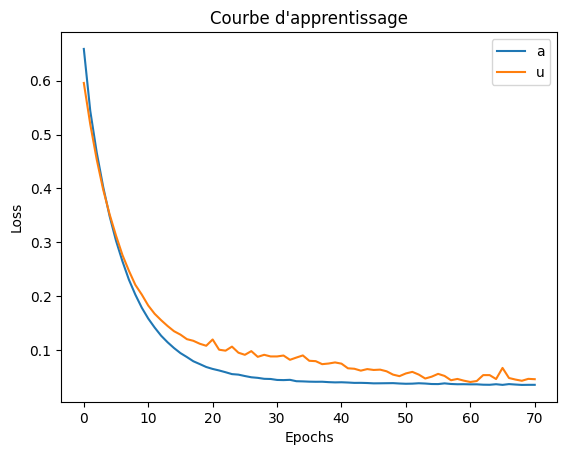

In [133]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(history_R128.history['loss'], label='train')        # Pertes d'entraînement
plt.plot(history_R128.history['val_loss'], label='test')     # Pertes de validation
plt.legend("autoencodeur R128")
plt.title('Courbe d\'apprentissage')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Autoencodeur convolutionnel (CAE) redimen resized (256x256) 

In [140]:
# Configuration des dimensions des images
IMG_SIZE = 256                        # Taille des images (256x256)
IMG_CHANNELS = 3                      # Canaux des images (RVB)
NB_EPOCHS_DENOISE = 100               # nombre epoch alogithme debruiter
BATCH_SIZE        = 64          # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage
latent_dim = 112                  #latent space dimension
# Configuration de l'encodeur (input = image de 128x128 avec 3 canaux)
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [142]:
# Encoder
input_img = tf.keras.Input(shape=input_shape)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)  # Réduction 128x128 -> 64x64
x = MaxPooling2D((2, 2), padding='same')(x)  

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu')(x)  # Réduction 64x64 -> 32x32
x = MaxPooling2D((2, 2), padding='same')(x)  

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu')(x)  # Réduction 32x32 -> 16x16
x = MaxPooling2D((2, 2), padding='same')(x)  # 128x128 -> 64x64

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
encoded = Conv2D(512, (3, 3), activation='relu')(x)  # Réduction 16x16 -> 8x8
encoded = MaxPooling2D((2, 2), padding='same')(x)  

# Modèle de l'encodeur
encoder_model_R256 = Model(inputs=input_img, outputs=encoded)

# Afficher le résumé de l'encodeur
encoder_model_R256.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 254, 254, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 127, 127, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 127, 127, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 63, 63, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 63, 63, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 61, 61, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 31, 31, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 31, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,329,408 (8.89 MB)

 Trainable params: 2,327,488 (8.88 MB)

 Non-trainable params: 1,920 (7.50 KB)

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


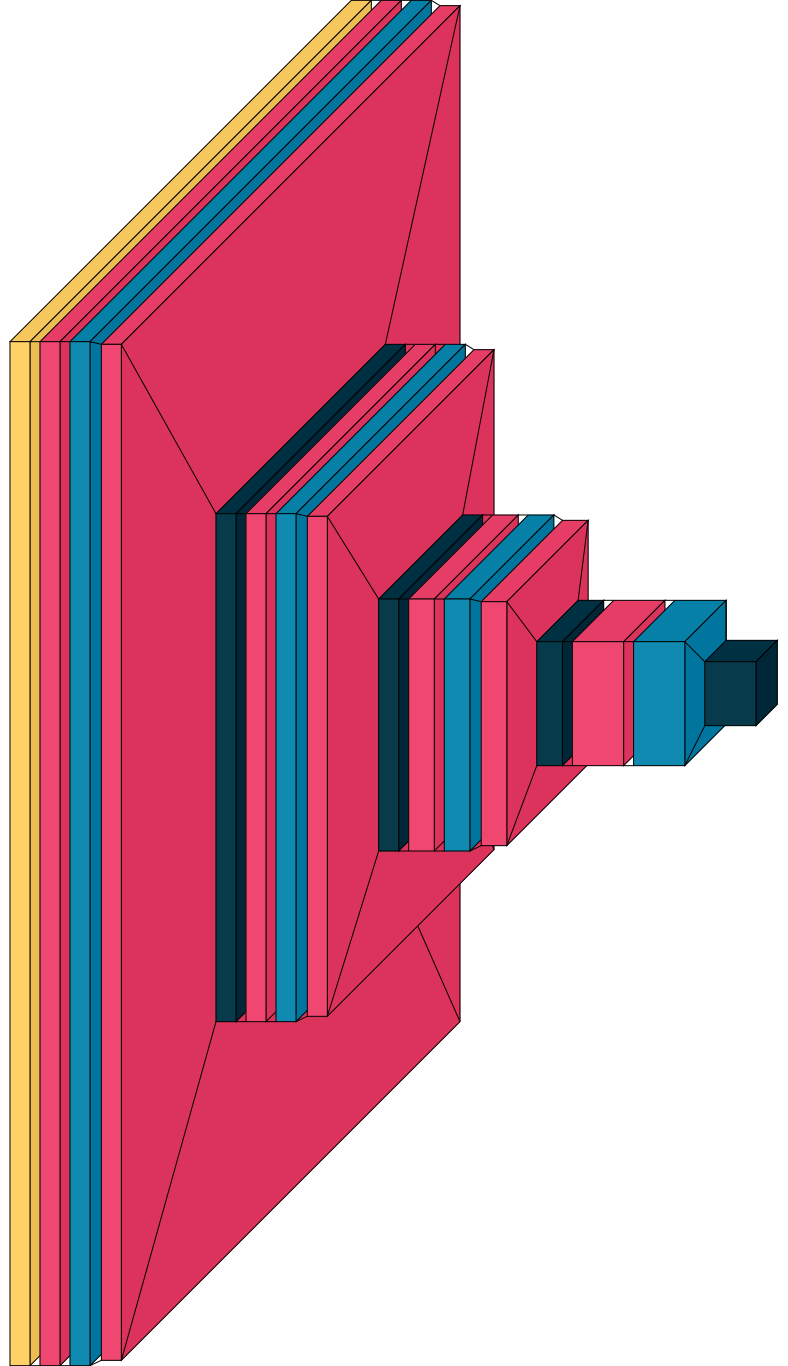

In [143]:
import visualkeras
visualkeras.layered_view(encoder_model_R256).show() # display using your system viewer
visualkeras.layered_view(encoder_model_R256)

In [146]:
x = Flatten()(encoded)
latent = Dense(latent_dim, activation='relu')(x)
latent = Dropout(0.4)(latent)

In [148]:
# Optimiseur RMSprop 
optimizer = RMSprop()

# Fonction de perte MSE 
loss = 'mse'

x = Dense(16 * 16 * 512, activation='relu')(latent)
x = Reshape((16, 16, 512))(x)  # On part d'une taille 16x16 au lieu de 8x8

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 16x16 -> 32x32

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 32x32 -> 64x64

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 64x64 -> 128x128

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 128x128 -> 256x256

# Reconstruction finale pour une image RVB (3 canaux)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Reconstruction finale

# Modèle du décodeur
decoder_model_R256 = Model(inputs=latent, outputs=decoded)

# Compilation du modèle
decoder_model_R256.compile(optimizer=optimizer, loss=loss)

# Affichage du résumé du modèle
decoder_model_R256.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_297CLONE           │ (None, 112)            │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 131072)         │    14,811,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_30 (UpSampling2D) │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_31 (UpSampling2D) │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_32 (UpSampling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_33 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,725,251 (71.43 MB)

 Trainable params: 18,723,331 (71.42 MB)

 Non-trainable params: 1,920 (7.50 KB)

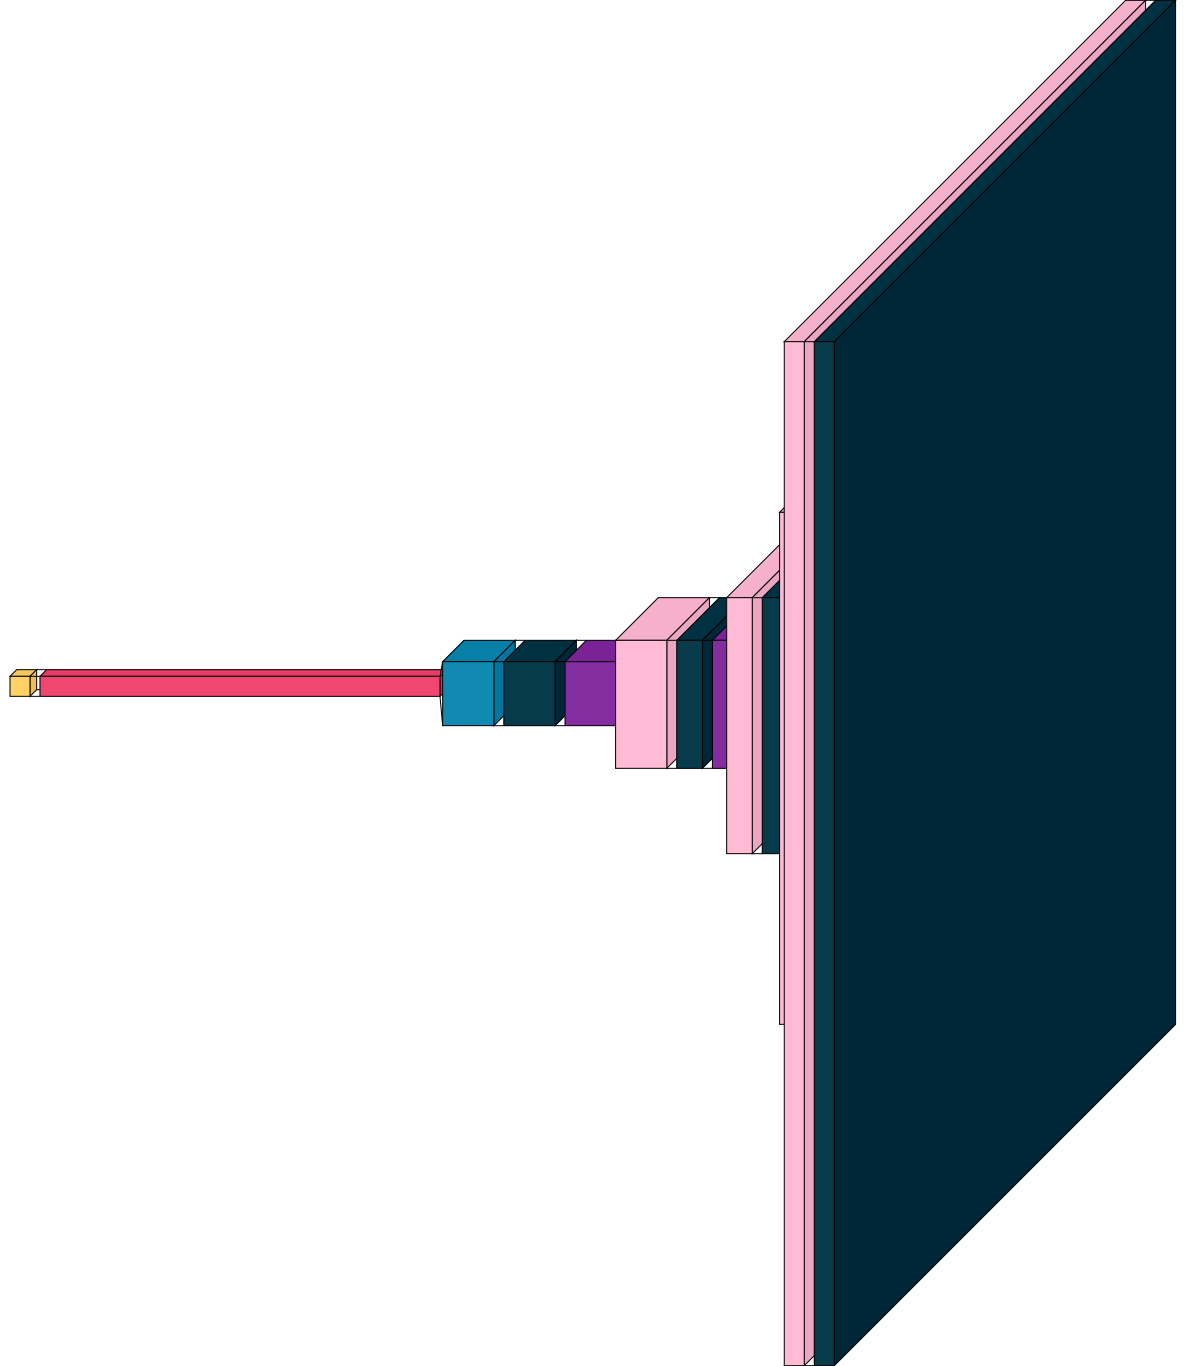

In [149]:
import visualkeras
visualkeras.layered_view(decoder_model_R256).show() # display using your system viewer
visualkeras.layered_view(decoder_model_R256)

In [151]:
# Construire le modèle
# Construire le modèle
autoencoder_R256 = Model(input_img, decoded)

# Compiler le modèle avec les meilleurs hyperparamètres
autoencoder_R256.compile(optimizer=optimizer, loss=loss)

# Affichage du résumé du modèle
autoencoder_R256.summary()_R256 = Model(input_img, decoded)

# Compiler le modèle avec les meilleurs hyperparamètres
autoencoder_R256.compile(optimizer=optimizer, loss=loss)

# Affichage du résumé du modèle
autoencoder_R256.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 254, 254, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 127, 127, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 127, 127, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 63, 63, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 63, 63, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 61, 61, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 31, 31, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 31, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 112)            │    14,680,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 131072)         │    14,811,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 16, 16, 512)    │         2,04

 Total params: 35,734,835 (136.32 MB)

 Trainable params: 35,730,995 (136.30 MB)

 Non-trainable params: 3,840 (15.00 KB)

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


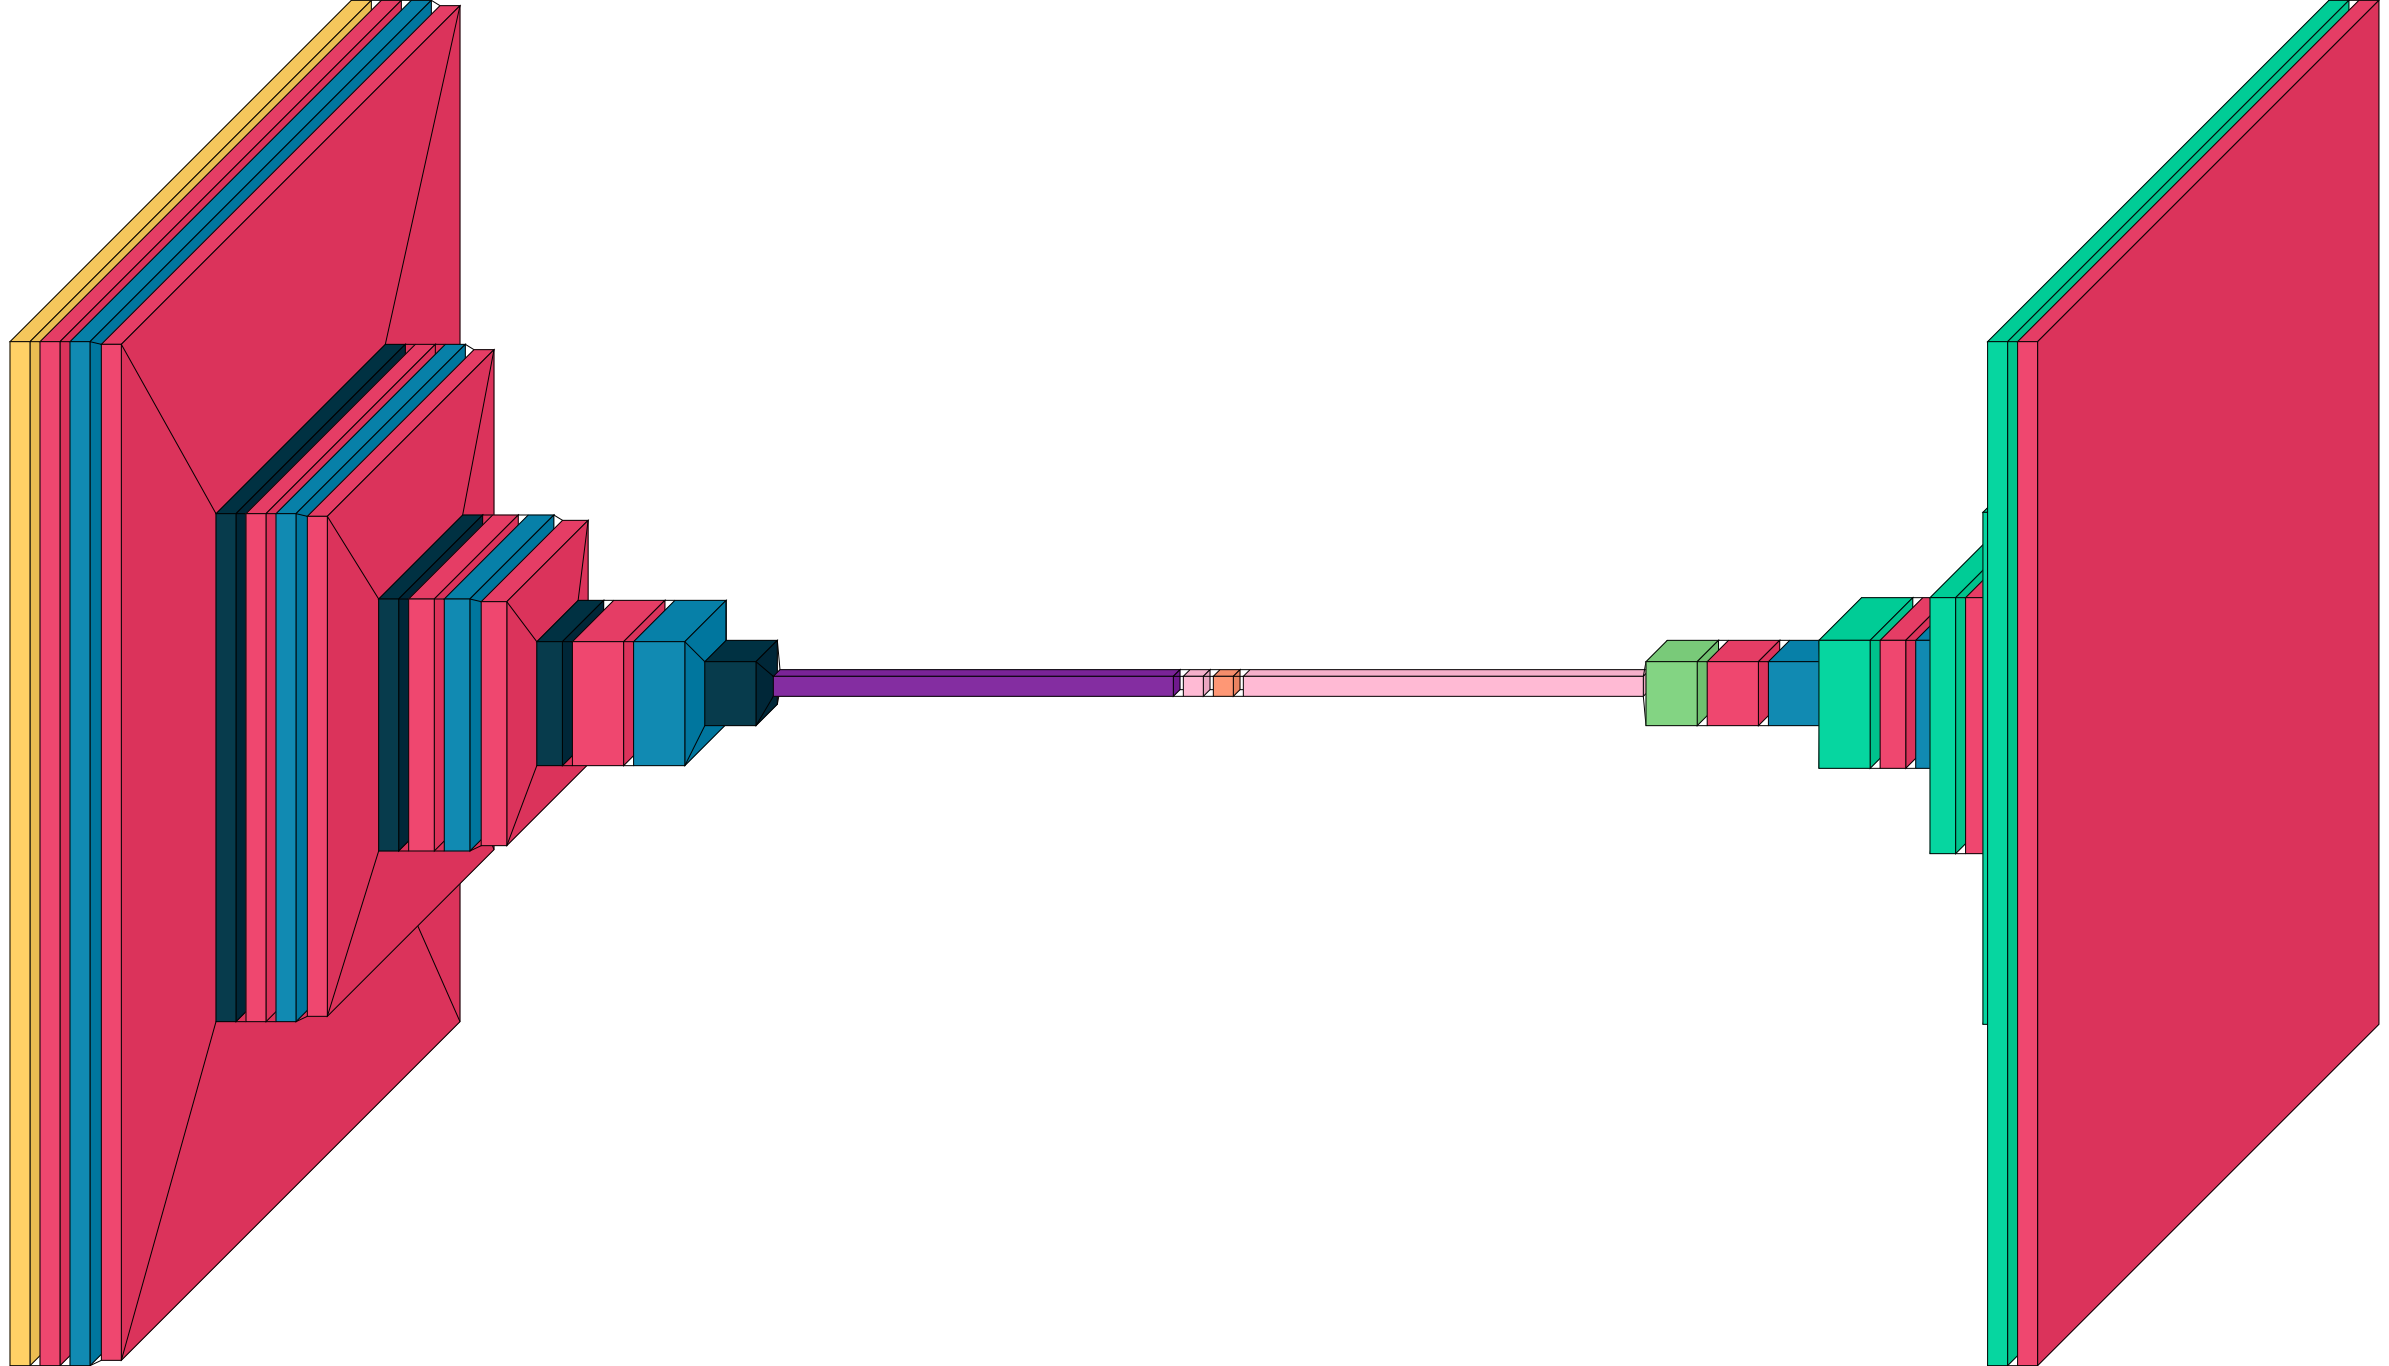

In [152]:
import visualkeras
visualkeras.layered_view(autoencoder_R256).show() # display using your system viewer
visualkeras.layered_view(autoencoder_R256)

In [153]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [154]:

# Train the model
history_R256 = autoencoder.fit(
    train_noisy_augmented_L1000_R256, train_images_augmented_L1000_R256,     # Données d'entrée bruitées et images originales correspondantes
    epochs=NB_EPOCHS_DENOISE,   # Nombre d'epochs défini précédemment
    batch_size=BATCH_SIZE,      # Taille de batch définie précédemment
    shuffle=True,               # Shuffle des données à chaque epoch
    validation_data=(test_noisy_augmented_L1000_R256, test_images_augmented_L1000_R256),  # Validation avec les images de test bruitées et originales
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False), early_stopping]  # Une seule liste pour les callbacks
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - loss: 0.7082 - val_loss: 0.5985
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - loss: 0.5665 - val_loss: 0.5207
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 102s 8s/step - loss: 0.4849 - val_loss: 0.4550
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - loss: 0.4167 - val_loss: 0.3977
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 0.3596 - val_loss: 0.3505
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - loss: 0.3133 - val_loss: 0.3091
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - loss: 0.2701 - val_loss: 0.2744
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 0.2354 - val_loss: 0.2447
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 0.2087 - val_loss: 0.2197
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - loss: 0.1821 - val_loss: 0.1985
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - loss: 0.1603 - val_loss: 0.1822
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/ste

In [156]:
autoencoder_R256.save_weights('autoencoder_L1000_R256.weights.h5')

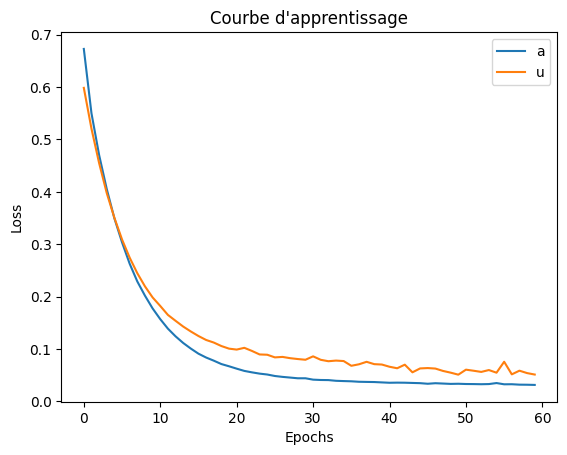

In [158]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(history_R256.history['loss'], label='train')        # Pertes d'entraînement
plt.plot(history_R256.history['val_loss'], label='test')     # Pertes de validation
plt.legend("autoencodeur R256")
plt.title('Courbe d\'apprentissage')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [181]:
# Vérifiez la forme des images d'entrée
print(f"Forme des données d'entraînement : {train_noisy_augmented_L1000_R128.shape}")
print(f"Forme des données de test : {test_noisy_augmented_L1000_R128.shape}")

# Vérifiez la forme d'entrée du modèle
print(f"Forme d'entrée attendue par le modèle : {autoencoder.input_shape}")


Forme des données d'entraînement : (800, 128, 128, 3)
Forme des données de test : (200, 128, 128, 3)
Forme d'entrée attendue par le modèle : (None, 128, 128, 3)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step


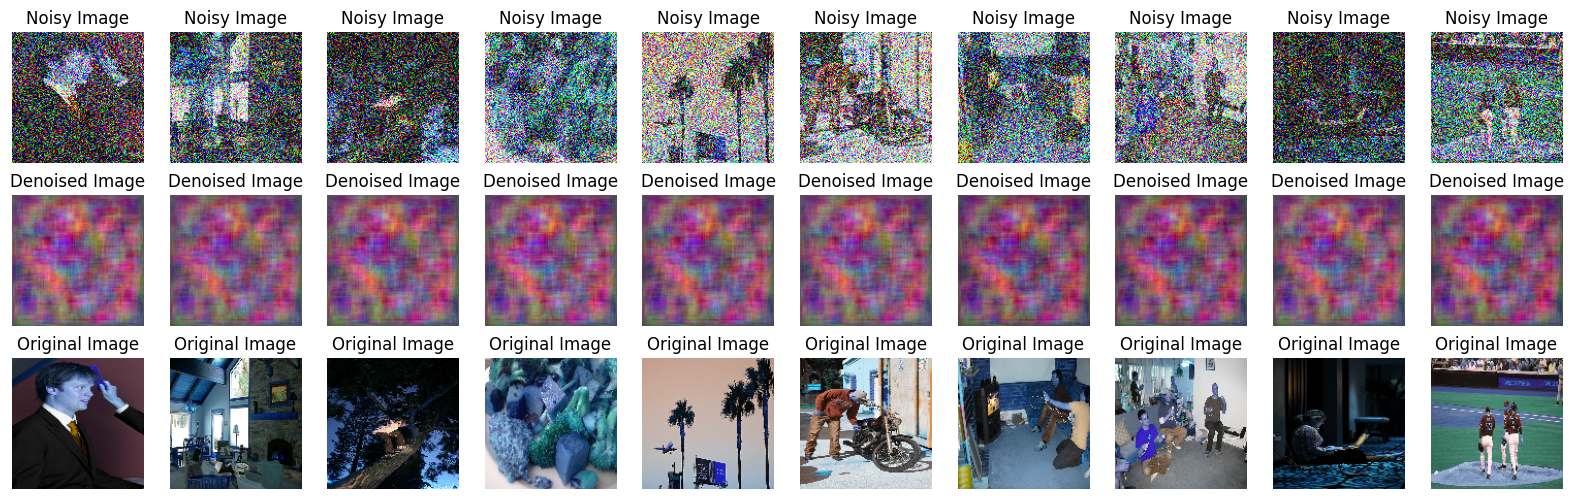

In [182]:
import numpy as np
import matplotlib.pyplot as plt

# Prédiction des images débruitées avec l'autoencodeur
decoded_imgs = autoencoder.predict(test_noisy_augmented_L1000_R128)

# Fonction pour normaliser les images pour l'affichage
def normalize_image(image):
    """
    Normalise les images à une plage de 0 à 1 pour une meilleure visualisation.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Nombre d'images à afficher
n = 10

# Initialisation de la figure pour l'affichage
plt.figure(figsize=(20, 6))

# Boucle pour afficher les images bruitées, débruitées et originales
for i in range(n):
    # Affichage des images bruitées
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(normalize_image(test_noisy_augmented_L1000_R128[i]))
    plt.title("Noisy Image")
    plt.axis("off")

    # Affichage des images débruitées
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(normalize_image(decoded_imgs[i]))
    plt.title("Denoised Image")
    plt.axis("off")

    # Affichage des images originales
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(normalize_image(test_images_augmented_L1000_R128[i]))
    plt.title("Original Image")
    plt.axis("off")

# Afficher la figure avec toutes les images
plt.show()


